In [17]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install gym
#!pip install pygame

In [18]:
from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt


from IPython.display import HTML

# Gym is a library for reinforcement learning
# It provides a simple interface to a large number of tasks, including
#Classic control tasks (CartPole, Pendulum)
#Classic video games 
#Continuous control tasks
#Robotic arm manipulation

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):
    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
            probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                    annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()
        

def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()

plt.rcParams['animation.ffmpeg_path'] = 'C:\\Anaconda3\\2023.03-1\\Library\\bin\\ffmpeg.EXE'


def plot_values2(state_values, frame, action_meanings=None):
    f, axes = plt.subplots(2, 2, figsize=(10, 10))
    f.suptitle("Action Values", size=20)
    axes = axes.flatten()

    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}

    for action in range(4):
        ax = axes[action]
        sns.heatmap(state_values[:, :, action], annot=True, fmt=".2f", cmap='coolwarm',
                    annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=ax)
        ax.set_title(f"Action: {action_meanings[action]}")

    axes[-1].imshow(frame)
    for ax in axes:
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid suptitle overlap
    plt.show()
    

def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                        interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

        return display_video(frames)



In [19]:
import gym
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
env = Maze() # 5 x 5 set

In [20]:
initial_state = env.reset() # this method reset the environment to its initial state to  and returns it so that the agent can observe it.
print(f"The new episode will start in state: {initial_state}") 

The new episode will start in state: (0, 0)


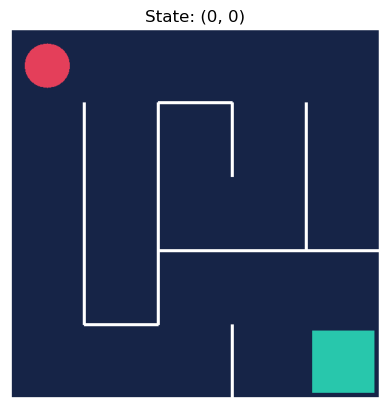

In [21]:
frame = env.render(mode='rgb_array') # this method (render) e a visual to the current state in the env. 
plt.axis('off')
plt.title(f"State: {initial_state}") # it set the state to initial state 
plt.imshow(frame) # matplotlib to show image

In [22]:
action = 2 
next_state, reward, done, info = env.step(action) # gym give another method to control action "step" its apply action selected by the agent in the environment
print(f"After moving down 1 row, the agent is in state: {next_state}") # it return: The next state / reward obtained / T/F  the task has been completed /  other relevant information in a python dictionary
print(f"After moving down 1 row, we got a reward of: {reward}")
print("After moving down 1 row, the task is", "" if done else "not", "finished")

After moving down 1 row, the agent is in state: (1, 0)
After moving down 1 row, we got a reward of: -1.0
After moving down 1 row, the task is not finished


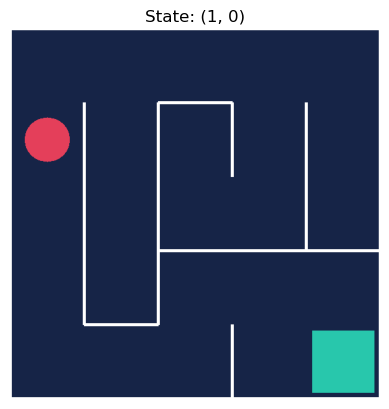

In [23]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f"State: {next_state}")
plt.imshow(frame) #to show the previos action selection and where the agent in which state 

In [24]:
env.close() # another methode to close the control task by gym 

In [25]:
env = Maze() # 5 x 5 set

In [26]:
# The states of a tuple of two integers, both in the range [0, 4], representing the row and column in which the agent is currently located:
# s=(row,column)row,column∈{0,1,2,3,4}

In [27]:
print(f"For example, the initial state is: {env.reset()}")
print(f"The space state is of type: {env.observation_space}") # gym library store the state in the env.observation_space 

For example, the initial state is: (0, 0)
The space state is of type: MultiDiscrete([5 5])


In [28]:
print(f"An example of a valid action is: {env.action_space.sample()}") # sample pick random action in the env 
print(f"The action state is of type: {env.action_space}")

An example of a valid action is: 1
The action state is of type: Discrete(4)


In [29]:
# 0 -> move up
# 1 -> move right
# 2 -> move down
# 3 -> move left

In [30]:
env = Maze()
state = env.reset()
trajectory = [] # initializes an empty list to store information about each step in the agent's interaction with the environment.
for _ in range(10):
    action = env.action_space.sample()
    next_state, reward, done, extra_info = env.step(action)
    trajectory.append([state, action, reward, done, next_state]) # the trajectory have these elements 
    state = next_state
env.close()

print(f"trajectory:\n{trajectory}")

trajectory:
[[(0, 0), 0, -1.0, False, (0, 0)], [(0, 0), 0, -1.0, False, (0, 0)], [(0, 0), 2, -1.0, False, (1, 0)], [(1, 0), 1, -1.0, False, (1, 0)], [(1, 0), 1, -1.0, False, (1, 0)], [(1, 0), 1, -1.0, False, (1, 0)], [(1, 0), 0, -1.0, False, (0, 0)], [(0, 0), 0, -1.0, False, (0, 0)], [(0, 0), 2, -1.0, False, (1, 0)], [(1, 0), 0, -1.0, False, (0, 0)]]


In [31]:
env.close() 

In [32]:
import numpy as np  # Allows working with vectors and matrices and represents the value table
import matplotlib.pyplot as plt  # Used for plotting and visualization

In [33]:
env = Maze()

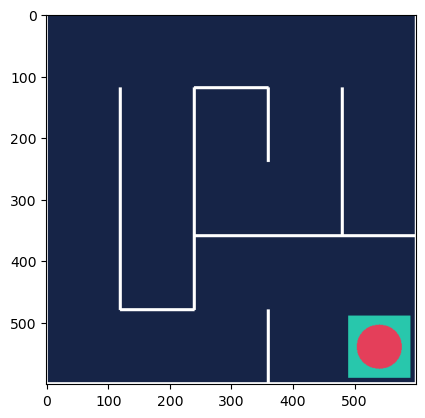

In [34]:
frame = env.render(mode='rgb_array') # to show the env visually 
plt.axis('on') 
plt.imshow(frame)

In [35]:
print(f"Observation space shape: {env.observation_space.nvec}") # nvec > num of row and colm of the state 
print(f"Number of actions: {env.action_space.n}") # n > varble store the avilable action that the agent can chose from

Observation space shape: [5 5]
Number of actions: 4


In [36]:
policy_probs = np.full((5, 5, 4), 0.25) # Create a table for the agent policy (the probeplty will change throug the learning process)

In [37]:
def policy(state):
    return policy_probs[state] # to look at the state and find the right probelty for each state 

In [41]:
action_probabilities = policy((0,0)) # test policy with state 0,0 
for action, prob in zip(range(4), action_probabilities):
    print(f"Probability of taking action {action}: {prob}")

Probability of taking action 0: 0.25
Probability of taking action 1: 0.25
Probability of taking action 2: 0.25
Probability of taking action 3: 0.25


In [42]:
#test_agent(env, policy, episodes=5) not importent it just show a vid

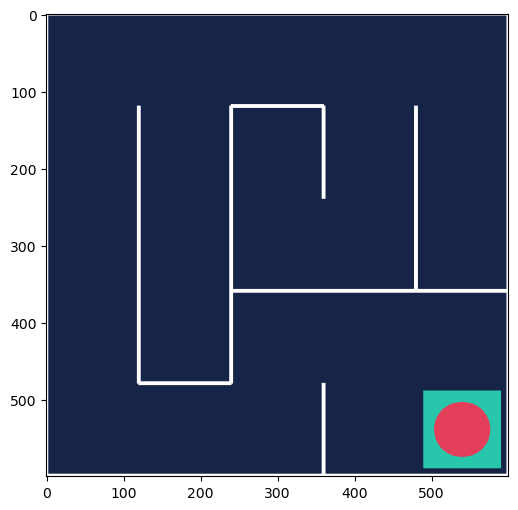

In [43]:
frame = env.render(mode='rgb_array')
plt.figure(figsize=(6,6))
plt.axis('on')
plt.imshow(frame)

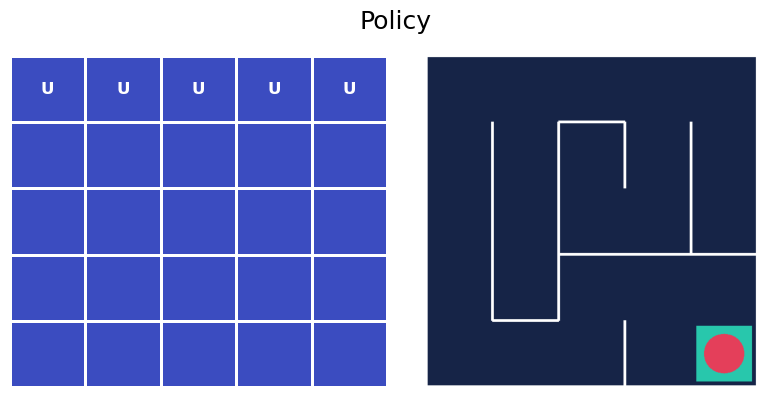

In [44]:
plot_policy(policy_probs,frame) # dision making of the agent in each state,  intial policy def the agent have the same action  

In [45]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [5 5]
Number of actions: 4


In [46]:
import shutil

ffmpeg_path = shutil.which('ffmpeg')

if ffmpeg_path:
    print(f"Path to ffmpeg: {ffmpeg_path}")
else:
    print("ffmpeg not found. Please make sure it's installed.")

ffmpeg not found. Please make sure it's installed.


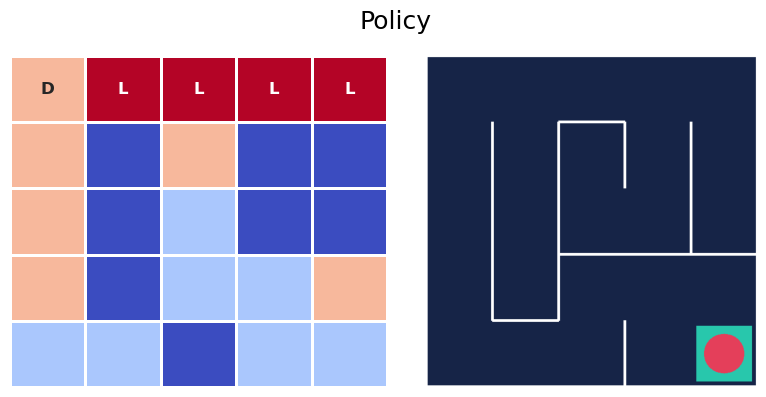

In [64]:
plot_policy(policy_probs, frame)
# !pip install ffmpeg

In [65]:
state_values = np.zeros(shape=(5,5)) #estameate of the value in each state = 0 
#state_values = np.full(shape=(5,5),  fill_value=0.0) #estameate of the value in each state = 0 

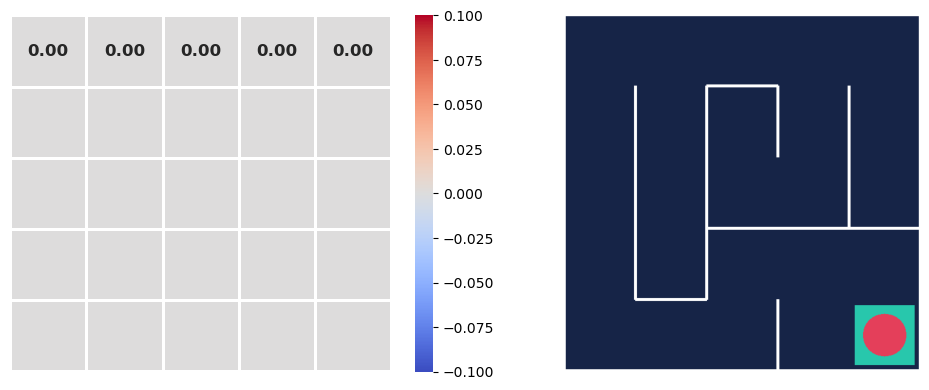

In [66]:
plot_values(state_values, frame)

In [67]:
def value_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):    # def tne fun , the policy probabilities table
    # state value estmate table, theta a pramater determines stopping the alpgarthem  ,  gamma balance between short-term and long-term considerations  
    delta = float('inf')    #  to measure the change in state values during each iteration
    iteration_count = 0
    
    while delta > theta:   # continue the loop until delta is smaller than theta.
        delta = 0   
        for row in range(5): #loop through rows in the state space
            for col in range(5):  # loop through columns in the state space.
                old_value = state_values[(row, col)] # Store the old value of the current state (by the state num)
                action_probs = None # initialize action probabilities for the current state.
                max_qsa = float('-inf') # Initialize action probabilities for the current state
           

                for action in range(4): # Loop through possible actions
                    next_state, reward, _, _ = env.simulate_step((row, col), action) # take the output of the input ((row, col), action) 
                    qsa = reward + gamma * state_values[next_state] # calculate the Q-value for the current action.
                    if qsa > max_qsa:
                        max_qsa = qsa
                        action_probs = np.zeros(4)
                        action_probs[action] = 1 # assigns a probability of 0.25 to the specified action and distributes the remaining probability (0.75) among the other possible actions 
                             
                state_values[(row, col)] = max_qsa # update the state value with the maximum Q-value.
                policy_probs[(row, col)] = action_probs # update the policy probabilities for the current state

                delta = max(delta, abs(max_qsa - old_value)) # update delta with the maximum difference between old and new values
                iteration_count += 1 #to count the iter. 

                
    print(f"Number of iterations: {iteration_count}")


In [68]:
# Smaller Value (1e-10): A smaller theta value makes the convergence criterion stricter. The algorithm will require a more precise convergence, potentially leading to more iterations but with a higher level of precision.

# Larger Value (1e-6): A larger theta value relaxes the convergence criterion, making the algorithm converge more quickly but potentially with a coarser level of precision.

# Smaller Value (gamma < 1): A smaller gamma places less emphasis on future rewards. This can make the agent focus more on immediate rewards, potentially leading to more short term behavior. It might be suitable for tasks where short-term rewards are more critical.

# Larger Value (gamma < 1): A larger gamma gives more weight to future rewards. This encourages the agent to consider long-term consequences and benefits, potentially leading to more strategic or far-sighted behavior. It is useful when the task involves delayed rewards and the agent needs to plan for the future.

# the discount factor (gsmma( affects how much the agent values future rewards compared to immediate rewards.
# When gamma is close to 1 ( 0.99), the agent is more forward-looking and considers long-term consequences,
# potentially leading to faster convergence. when gamma is lower (0.60 - 0.50), 
# the agent may focus more on immediate rewards, and the convergence might take longer.

In [69]:
value_iteration(policy_probs, state_values)

Number of iterations: 450


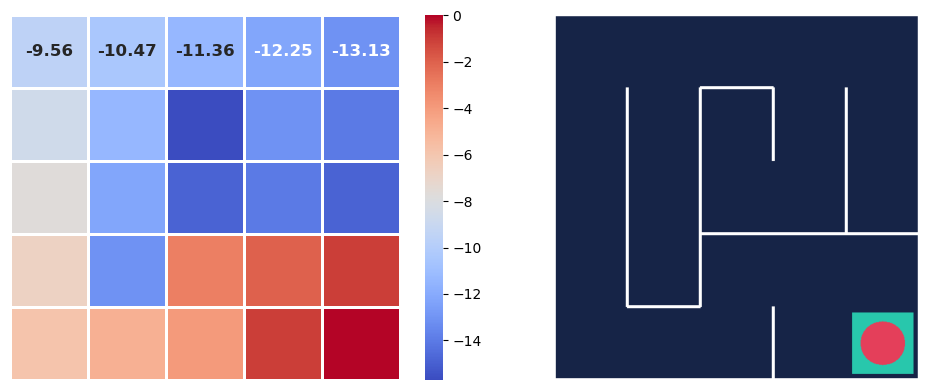

In [72]:
plot_values(state_values, frame) # need to check again why not showing all the state_val in the graph  

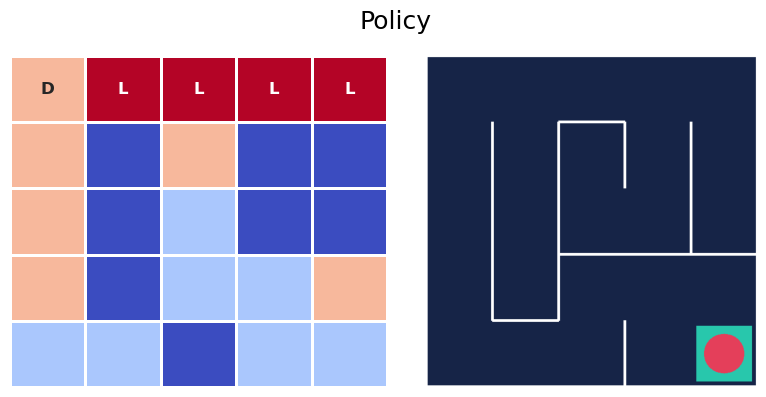

In [73]:
plot_policy(policy_probs, frame)

In [74]:
#test_agent(env, policy) #Test the resulting agent


In [75]:
# value iter take the acrion that max the return 
# policy evaluation is udate state value using the action that max the return

In [76]:
env.close() 
# everything below this still needs improvement and some are just for experiments propose

In [77]:
env = Maze()

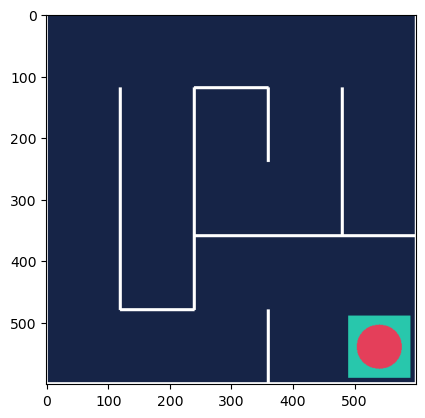

In [78]:
frame = env.render(mode='rgb_array')
plt.axis('on')
plt.imshow(frame)

In [79]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [5 5]
Number of actions: 4


In [80]:
policy_probs = np.full((5, 5, 4), 0.25)

In [81]:
def policy(state):
    return policy_probs[state]

In [82]:
action_probabilities = policy((0,0)) # test the policy with this state to chexk the prob is set to 0.25
for action, prob in zip(range(4), action_probabilities):
    print(f"Probability of taking action {action}: {prob}")

Probability of taking action 0: 0.25
Probability of taking action 1: 0.25
Probability of taking action 2: 0.25
Probability of taking action 3: 0.25


In [92]:
#test_agent(env, policy, episodes=1)

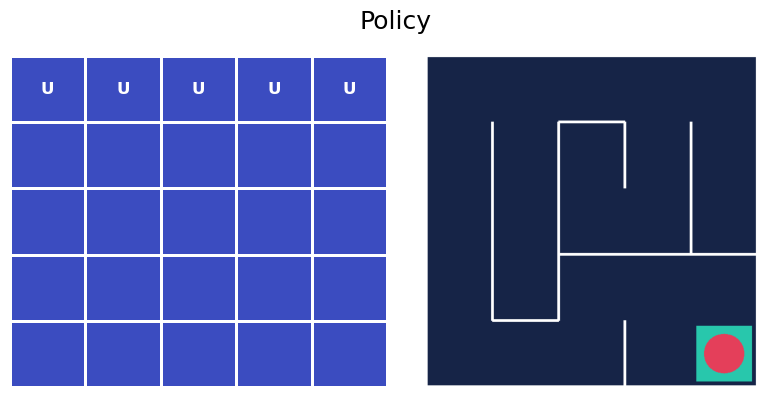

In [93]:
plot_policy(policy_probs, frame)

In [94]:
state_values = np.zeros(shape=(5,5)) # ceat the value table and set it to 0.0 

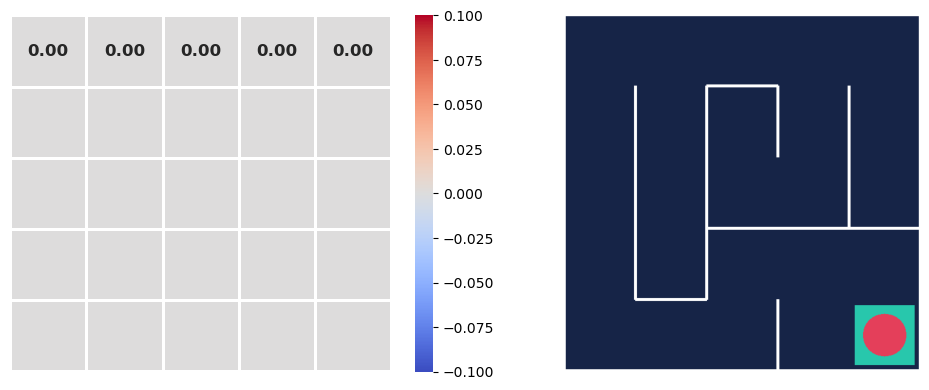

In [95]:
plot_values(state_values, frame)

In [96]:
def policy_evaluation(policy_probs, state_values, theta=1e-6, gamma=0.99): # evaluate the poicy in the present moment 
    delta = float("inf")                                             # that it take value table and make entry of the table 
 # (table store the prob of policy cosing each action , store the value of state, max error in value eastemation that allowed,gamma balance between short-term and long-term considerations
    while delta > theta:                                              # reflect the value of the state flowing that policy
        delta = 0

        for row in range(5):
            for col in range(5):
                old_value = state_values[(row, col)] # Store the old value of the current state (by the state num)
                new_value = 0  # initialize the new value of the current state
                action_probabilities = policy_probs[(row, col)] # retrieve actions probabilities for the current state

                for action, prob in enumerate(action_probabilities): # loop through possible actions and its probabilities
                    next_state, reward, _, _ = env.simulate_step((row, col), action)  # simulate the next state and reward for the action in present state
                    new_value += prob * (reward + gamma * state_values[next_state]) # the return that expect to obtain if we take that action
                                     #  which is the reward that we obtain simulated that step, plus the estimated value of the next state reched discoint by gamma
                state_values[(row, col)] = new_value # assign the state value with the new value

                delta = max(delta, abs(old_value - new_value)) # update delta with the max dif between old and new values (to stop this loop) 
                


In [97]:
def policy_improvement(policy_probs, state_values, gamma=0.99):

    policy_stable = True
    for row in range(5):
        for col in range(5):
            old_action = policy_probs[(row, col)].argmax() # get the old best action according to the current policy

            new_action = None
            max_qsa = float("-inf")

            for action in range(4):
                next_state, reward, _, _ = env.simulate_step((row, col), action)
                qsa = reward + gamma * state_values[next_state]
                if qsa > max_qsa:
                    max_qsa = qsa
                    new_action = action

            action_probs = np.zeros(4)
            action_probs[new_action] = 1.
            policy_probs[(row, col)] = action_probs

            if new_action != old_action:
                policy_stable = False

    return policy_stable

In [98]:
def policy_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):
    policy_stable = False

    while not policy_stable:

        policy_evaluation(policy_probs, state_values, theta, gamma)

        policy_stable = policy_improvement(policy_probs, state_values, gamma)

In [99]:
policy_iteration(policy_probs, state_values)

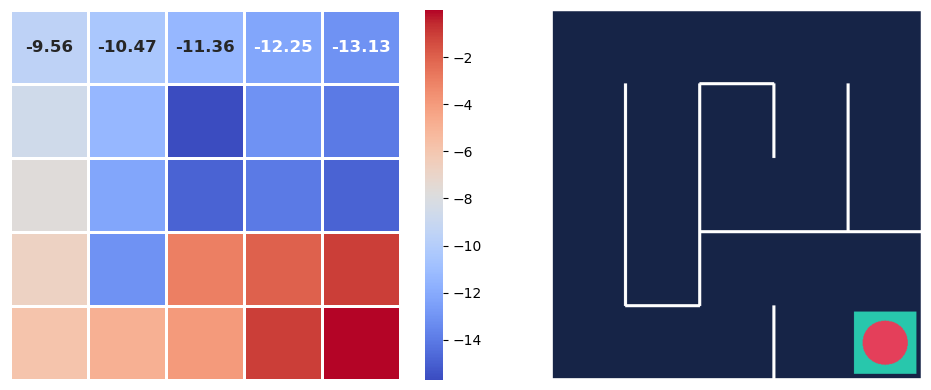

In [100]:
plot_values(state_values, frame)

In [ ]:
plot_policy(policy_probs, frame)

In [ ]:
env.close()


In [ ]:
env = Maze()

In [ ]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

In [ ]:
action_values = np.zeros(shape=(5, 5, 4))

action = policy((0,0))
print(f"Action taken in state (0,0): {action}")

In [ ]:
plot_values2(action_values, frame)

In [ ]:
def constant_alpha_mc(policy, action_values, episodes, gamma=0.99, epsilon=0.2, alpha=0.1):

    for episode in range(1, episodes+1):
        state = env.reset()
        done = False
        transitions = []

        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            transitions.append([state, action, reward])
            state = next_state

        G = 0
        for state_t, action_t, reward_t in reversed(transitions):
            G = reward_t + gamma * G
            action_values[state_t][action_t] += alpha * (G - action_values[state_t][action_t])

In [ ]:
constant_alpha_mc(policy, action_values, episodes=100)

In [ ]:
plot_values2(action_values, frame) # how to compine them in one graph do i need to defide each cel to 4? 

In [ ]:
plot_policy(action_values, frame) # this is not correct why??? 

In [ ]:
action_values = np.zeros(shape=(5, 5, 4)) # def q value table (q(s,a))

In [ ]:
plot_action_values(action_values)

In [ ]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

In [ ]:
action = policy((0,0))
print(f"Action taken in state (0,0): {action}")

In [ ]:
plot_policy(action_values, frame)


In [ ]:
def constant_alpha_mc(policy, action_values, episodes, gamma=0.99, epsilon=0.2, alpha=0.1): # mont carlo

    for episode in range(1, episodes+1):
        state = env.reset()
        done = False
        transitions = []

        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            transitions.append([state, action, reward])
            state = next_state

        G = 0
        for state_t, action_t, reward_t in reversed(transitions):
            G = reward_t + gamma * G
            action_values[state_t][action_t] += alpha * (G - action_values[state_t][action_t])

In [ ]:
constant_alpha_mc(policy, action_values, episodes=1000)

In [ ]:
# controls the size of the update made to the current estimate of a value or policy

In [ ]:
plot_action_values(action_values)